# PDAC Calibration - 1y probability changes - post-NOD

Author: Sophie Wagner, sw3767@cumc.columbia.edu

## Packages, notebook preferences, etc.

In [1]:
# Required Packages
import numpy as np  # For matrix manipulation
import pandas as pd  # For output/input data processing
import matplotlib.pyplot as plt  # For visualizations
from csaps import csaps
from tqdm import tqdm
from datetime import datetime
import random 

# Add the src directory to the Python path
import sys
import os
sys.path.append(os.path.abspath('../src'))

# Load .py files
import common_functions as func
import calibration_plots as p
import configs as c
import gof

# Some aesthetic options
np.set_printoptions(suppress=True, linewidth=300, formatter={'float': '{: 0.9f}'.format})
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Set up matrix

In [2]:
def row_normalize(matrix):
    # Loop over ages where we actually adjust parameters
    for age_layer in (c.ages_to_smooth - c.starting_age):
        layer = matrix[age_layer]
        for row_idx in range(layer.shape[0]):  # Loop over each row
            row = layer[row_idx]
            non_diag_sum = np.sum(row) - row[row_idx] 
            
            if non_diag_sum > 1:  # If the non-diag probabilities exceed 1
                scaling_factor = 1 / non_diag_sum
                row *= scaling_factor  # Scale 
            
            row[row_idx] = max(0, 1 - non_diag_sum)
    
    return matrix.clip(0.0,1.0)

def create_matrix():
    
    matrix = np.zeros((len(c.age_layers), len(c.health_states_itos), len(c.health_states_itos)))
    age_50_idx = 6 if c.param_interval == 5 else 30
    matrix[:, 0, 1] = 1-(1-0.0011)**(1/25) # average risk after 50 ~ 0.0011, transformed to annual prob
    matrix[:age_50_idx, 0, 1] = np.linspace(0.000001,matrix[-1,0,1],age_50_idx)
    matrix[:, 1, 2] = 0.380016 # c.model_inputs_dict['p_Local_to_Regional_PC']  
    matrix[:, 2, 3] = 0.666632 # c.model_inputs_dict['p_Regional_to_Distant_PC']
    matrix[:, 1, 4] = 0.040325 # c.model_inputs_dict['p_symptom_local'] 
    matrix[:, 2, 5] = 0.328861 # c.model_inputs_dict['p_symptom_regional']
    matrix[:, 3, 6] = 0.332143 # c.model_inputs_dict['p_symptom_distant']
    
    matrix = add_acm(matrix)  # ACM
    matrix = add_csd(matrix)  # CSD
    matrix = constrain_matrix(matrix)  # constrain
    matrix = row_normalize(matrix)  # normalize

    return matrix


def constrain_matrix(matrix):
    
    matrix[:, 0, 1] = np.maximum(matrix[:,0,1], 0.0000001)
    # matrix[:, 0, 1] = np.maximum.accumulate(matrix[:, 0, 1])
    matrix[:, 1, 2] = np.maximum(matrix[:, 0, 1], matrix[:, 1, 2])
    matrix[:, 2, 3] = np.maximum(matrix[:, 1, 2], matrix[:, 2, 3])
    matrix[:, 2, 5] = np.maximum(matrix[:, 1, 4], matrix[:, 2, 5])
    matrix[:, 3, 6] = np.maximum(matrix[:, 2, 5], matrix[:, 3, 6])
    
    return matrix


def add_acm(matrix):
    
    # Note: c.acm_rates configured for either 1y or 5y acm
    matrix[:, :7, 8] = c.acm_rates[:, np.newaxis]
    matrix[:, 8, 8] = 1
    
    return matrix


def add_csd(matrix):  # Constant death rate in calibration
    
    matrix[:, 4, 7] = c.model_inputs_dict['p_local_death']
    matrix[:, 5, 7] = c.model_inputs_dict['p_regional_death']
    matrix[:, 6, 7] = c.model_inputs_dict['p_distant_death']
    matrix[:, 7, 7] = 1
    
    return matrix

## Markov model

In [3]:
def run_markov(matrix, starting_age=20, max_age=84):
    
    current_age = starting_age
    age_layer = 0
    month_pop, pop_log = c.starting_pop, c.starting_pop  # (13, 1)
    inc_log = np.zeros(pop_log.shape)  # to track new incidences in each state
    matrixT = matrix.transpose(0,2,1)  # (13, 9, 9)
    inflow_matrix = np.tril(matrixT, k=-1)
    
    while current_age < max_age:            

        # Matrix multiplication (state transition)
        mat, inflow_mat = matrixT[age_layer], inflow_matrix[age_layer] 
        month_inc = np.matmul(inflow_mat, month_pop)  # (9, 9)(9, 1)->(9, 1)
        month_pop = np.matmul(mat, month_pop)  # (9, 9)(9, 1)->(9, 1)
         
        # Add to log
        inc_log = np.concatenate((inc_log, month_inc), axis=1)  # (13, 65)
        pop_log = np.concatenate((pop_log, month_pop), axis=1)  # (13, 65)
        
        current_age += 1
        if current_age in c.ages_1y:
            age_layer += 1
            
    incidence, incidence_unadj = inc_log.copy(), inc_log.copy()
    dead_factor = np.divide(c.N, c.N - pop_log[7:, :].sum(axis=0))  # inc and prev denominator is out of living only
    prevalence = np.zeros(pop_log.shape) 

    for state in range(9):
        incidence[state, :] = np.multiply(incidence[state, :], dead_factor)
        prevalence[state, :] = np.multiply(pop_log[state, :], dead_factor)

    return incidence, prevalence, incidence_unadj, pop_log

## Calibration

In [4]:
def step(matrix, step_size, num_adj=3):
    """
    Updates a parameter matrix, using reduced 5-y interval matrix (to reduce number of
    parameters to adjust, faster convergence, smoother parameter change). Randomly 
    selected transitions and age groups are adjusted by a scaled step size, then smoothed
    and interpolated to get yearly values.

    Args:
        matrix (numpy.ndarray): Full parameter matrix for all ages and transitions.
        step_size (float): Scale of parameter adjustments.
        num_adj (int): Number of parameters to modify.

    Returns:
        numpy.ndarray: Updated matrix with smoothed yearly transition probabilities.
    """
    points = list(c.transitions_itos.keys()) 
    step_tp = random.choices(points, k=num_adj)
    step_age = random.choices(c.ages_to_smooth-20, k=num_adj)
    new_matrix = matrix.copy()
    
    for i in range(num_adj):
        (from_state, to_state), age = step_tp[i], step_age[i]
        old_param = new_matrix[age, from_state, to_state] 
        step_param = (old_param * step_size).clip(0.0001, 0.1)
        new_matrix[age, from_state, to_state] += np.random.uniform(low=-step_param, high=step_param)

    # Smooth from age 55-62, extract values from 57-62 while preserving values from 20-56
    small_matrix = new_matrix[c.ages_to_smooth,:,:]
    smoothed_matrix = csaps(c.ages_to_smooth, small_matrix, smooth=0.7, axis=0)(c.ages_to_smooth).clip(0.0,1.0)
    new_matrix[c.ages_to_smooth,:,:] = smoothed_matrix
    assert new_matrix.shape[0]==65
    
    new_matrix = add_acm(new_matrix)  # ACM
    new_matrix = add_csd(new_matrix)  # CSD
    new_matrix = constrain_matrix(new_matrix)  # constrain
    new_matrix = row_normalize(new_matrix)  # normalize

    return new_matrix

In [5]:
def progress_report(iteration, best_eval, best_log, ticker, best_t):
    """
    Prints progress report during simulated annealing.
    """
    log_adj, _, inc_log, _ = best_log
    total_dxd = np.sum(inc_log[4:7, :]) / c.N
    print(f"{iteration}: Best Eval: {best_eval:.5f}, PDAC: {total_dxd:.5f}, Tick: {ticker}")
    
    if iteration % 10000 == 0:
        transition_probs = p.extract_transition_probs(best_t, metric="avg")
        print(f"Detailed Progress Report, Iteration = {iteration}")
        print(transition_probs)
        p.plot_vs_seer(log_adj, c.seer_inc_nod_full, show_plot=True)

In [6]:
def simulated_annealing(n_iterations, step_size, start_tmat, n_adj=5, starting_temp=1, verbose=False, print_interval=1000):
    """
    Performs simulated annealing to optimize a transition matrix.

    Args:
        n_iterations (int): Number of iterations for optimization.
        step_size (float): Step size for parameter adjustments.
        start_tmat (numpy.ndarray): Initial transition matrix.
        n_adj (int): Number of parameters to adjust per step.
        starting_temp (float): Initial temperature for annealing.
        verbose (bool): Whether to print progress reports.
        print_interval (int): Interval for progress reporting.

    Returns:
        numpy.ndarray: Optimized transition matrix.
    """
    best_t = np.copy(start_tmat)
    best_log = run_markov(best_t)
    best_eval = gof.objective(best_log)
    curr_t, curr_eval = best_t, best_eval
    scheduler, ticker, iter_count = 0, 0, 0 

    with tqdm(total=n_iterations, desc="Simulated annealing progress", unit="iteration") as pbar:
        for i in range(n_iterations):
            # Generate candidate solution
            candidate_t = step(np.copy(curr_t), step_size, n_adj)
            candidate_log = run_markov(candidate_t)
            candidate_eval = gof.objective(candidate_log)

            # Update best solution
            if candidate_eval < best_eval:
                ticker, scheduler = 0, 0
                best_t, best_eval = np.copy(candidate_t), candidate_eval
                best_log = run_markov(best_t)

                # Dynamically adjust parameters on improvement
                step_size = max(0.9 * step_size, 0.01)  # Decay step size slightly
                starting_temp = max(0.95 * starting_temp, 1)  # Gradual cooling
                n_adj = max(1, n_adj - 1)  # Reduce number of adjustments for precision
                
                # print(f"UPDATE ACCOMPLISHED at iteration {i}!")
                # print(f"Best Eval: {best_eval} | Step Size: {step_size:.4f} | Temp: {starting_temp:.2f} | n_adj: {n_adj}")
                
            else:
                ticker += 1
                iter_count+=1
                scheduler+=1

            # Calculate temperature and Metropolis acceptance criterion
            t = starting_temp / (1 + 0.01 * np.sqrt(iter_count + 1))  # Adaptive cooling
            diff = candidate_eval - curr_eval
            metropolis = np.exp(-diff / t)

            if diff < 0 or np.random.random() < metropolis:
                curr_t, curr_eval = np.copy(candidate_t), candidate_eval

            # Print progress report
            if verbose and i > 0 and i % print_interval == 0:
                progress_report(i, best_eval, best_log, ticker, best_t)

            # Adjust or reset exploration parameters periodically
            if scheduler > 50000:  # Long stagnation
                step_size = np.random.uniform(0.1, 0.3)  # Randomize step size
                starting_temp = np.random.uniform(10, 50)  # Reset temperature
                n_adj = np.random.choice(range(1, 12))  # Random adjustments
                scheduler, iter_count = 0, 0, 0 # Reset 
            elif scheduler > 15000:
                step_size = min(step_size + 0.05, 0.3)  # Increase step size for exploration
                starting_temp = min(starting_temp + 2, 50)  # Boost temperature for exploration
                n_adj = np.random.choice(range(3, 10))  # Randomize number of parameters to adjust
                scheduler, iter_count = 0, 0  # Reset stagnation counter

                
            pbar.update(1)

    print("Best evaluation:", best_eval)
    return best_t

## Run simulated annealing

In [7]:
def run_sa(tmat=None, save_all=False, n_iterations=50000, step_size=0.2, n_adj=5, starting_temp=1, print_interval=5000):
    
    start_tmat = None
    start_tmat = tmat if tmat is not None else create_matrix()   
    initial_score = gof.objective(run_markov(start_tmat))
    print(f"Initial score: {round(initial_score, 5)}")
    print("Starting calibration...")
    
    result = simulated_annealing(n_iterations=n_iterations, step_size=step_size, start_tmat=start_tmat, n_adj=n_adj, starting_temp=starting_temp, verbose=True, print_interval=print_interval)
    
    # Gather results
    timestamp = datetime.now().strftime("%Y%m%d_%H%M")
    curr_tmat = result.copy()
    curr_log = run_markov(curr_tmat)
    log_adj, log_prev, log_inc, pop_log = curr_log
    final_score = gof.objective(run_markov(curr_tmat))
    
    save = save_all
    
    print("Done.")
    
    # Saving
    if save:
        log_path, tmat_path, plot_path = c.OUTPUT_PATHS["logs"], c.OUTPUT_PATHS["tmats"], c.OUTPUT_PATHS["plots"]
        np.save(f"{tmat_path}/{timestamp}_tmat.npy", curr_tmat)
        pd.DataFrame(log_adj).to_csv(f"{log_path}/{timestamp}_inc_adj.csv")
        pd.DataFrame(log_prev).to_csv(f"{log_path}/{timestamp}_prev.csv")
        pd.DataFrame(log_inc).to_csv(f"{log_path}/{timestamp}_inc_unadj.csv")
        pd.DataFrame(pop_log.T).to_csv(f"{log_path}/{timestamp}_pop_log.csv")
        p.plot_vs_seer(log_adj, c.seer_inc, save_imgs=True, show_plot=False, outpath=plot_path, timestamp=timestamp)
        p.plot_vs_seer_total(log_adj, c.seer_inc, save_imgs=True, show_plot=False, outpath=plot_path, timestamp=timestamp)

    return curr_tmat

EPOCH 1/3 ----------------------------------------------------------
Initial score: 455629.55326
Starting calibration...


Simulated annealing progress:   0%|          | 0/100000 [00:00<?, ?iteration/s]

Simulated annealing progress:   0%|          | 46/100000 [00:00<10:33, 157.71iteration/s]C:\Users\sophi\AppData\Local\Temp\ipykernel_23840\2899436518.py:52: RuntimeWarning: overflow encountered in exp
  metropolis = np.exp(-diff / t)
Simulated annealing progress:   0%|          | 65/100000 [00:00<09:49, 169.45iteration/s]C:\Users\sophi\AppData\Local\Temp\ipykernel_23840\2899436518.py:52: RuntimeWarning: overflow encountered in exp
  metropolis = np.exp(-diff / t)
Simulated annealing progress:   0%|          | 102/100000 [00:00<09:28, 175.79iteration/s]C:\Users\sophi\AppData\Local\Temp\ipykernel_23840\2899436518.py:52: RuntimeWarning: overflow encountered in exp
  metropolis = np.exp(-diff / t)
Simulated annealing progress:   0%|          | 122/100000 [00:00<09:10, 181.48iteration/s]C:\Users\sophi\AppData\Local\Temp\ipykernel_23840\2899436518.py:52: RuntimeWarning: overflow encountered in exp
  metropolis = np.exp(-diff / t)
Simulated annealing progress:   0%|          | 218/100000 [00:

5000: Best Eval: 191494.70462, PDAC: 0.01056, Tick: 0


Simulated annealing progress:   5%|▌         | 5055/100000 [00:29<08:55, 177.21iteration/s]C:\Users\sophi\AppData\Local\Temp\ipykernel_23840\2899436518.py:52: RuntimeWarning: overflow encountered in exp
  metropolis = np.exp(-diff / t)
C:\Users\sophi\AppData\Local\Temp\ipykernel_23840\2899436518.py:52: RuntimeWarning: overflow encountered in exp
  metropolis = np.exp(-diff / t)
Simulated annealing progress:   5%|▌         | 5126/100000 [00:30<16:50, 93.89iteration/s] C:\Users\sophi\AppData\Local\Temp\ipykernel_23840\2899436518.py:52: RuntimeWarning: overflow encountered in exp
  metropolis = np.exp(-diff / t)
C:\Users\sophi\AppData\Local\Temp\ipykernel_23840\2899436518.py:52: RuntimeWarning: overflow encountered in exp
  metropolis = np.exp(-diff / t)
Simulated annealing progress:   5%|▌         | 5146/100000 [00:30<17:53, 88.38iteration/s]C:\Users\sophi\AppData\Local\Temp\ipykernel_23840\2899436518.py:52: RuntimeWarning: overflow encountered in exp
  metropolis = np.exp(-diff / t)
Sim

10000: Best Eval: 21808.45559, PDAC: 0.02052, Tick: 2
Detailed Progress Report, Iteration = 10000
   From State    To State   Age 30   Age 75      Min      Max      Avg
0     healthy  u_PDAC_loc  0.00000  0.00044  0.00000  0.00384  0.00075
1  u_PDAC_loc  u_PDAC_reg  0.14007  0.21068  0.12057  0.27205  0.17842
2  u_PDAC_reg  u_PDAC_dis  0.27514  0.49975  0.21804  0.65455  0.39397
3  u_PDAC_loc  d_PDAC_loc  0.02205  0.02029  0.01384  0.02719  0.02034
4  u_PDAC_reg  d_PDAC_reg  0.29325  0.25928  0.17236  0.36035  0.26619
5  u_PDAC_dis  d_PDAC_dis  0.54205  0.51850  0.32767  0.73153  0.52677


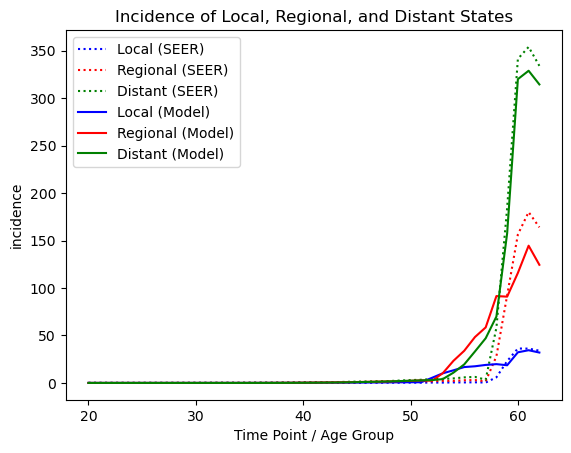

Simulated annealing progress:  15%|█▌        | 15029/100000 [01:24<07:18, 193.88iteration/s]

15000: Best Eval: 4794.42998, PDAC: 0.02021, Tick: 0


Simulated annealing progress:  20%|██        | 20000/100000 [01:49<06:37, 201.06iteration/s]

20000: Best Eval: 1493.57009, PDAC: 0.01943, Tick: 0
Detailed Progress Report, Iteration = 20000
   From State    To State   Age 30   Age 75      Min      Max      Avg
0     healthy  u_PDAC_loc  0.00000  0.00044  0.00000  0.00574  0.00073
1  u_PDAC_loc  u_PDAC_reg  0.14007  0.21068  0.10324  0.33089  0.17950
2  u_PDAC_reg  u_PDAC_dis  0.27514  0.49975  0.21804  0.71721  0.40277
3  u_PDAC_loc  d_PDAC_loc  0.02205  0.02029  0.01012  0.02787  0.02005
4  u_PDAC_reg  d_PDAC_reg  0.29325  0.25928  0.12085  0.38114  0.26400
5  u_PDAC_dis  d_PDAC_dis  0.54205  0.51850  0.26824  0.78820  0.53063


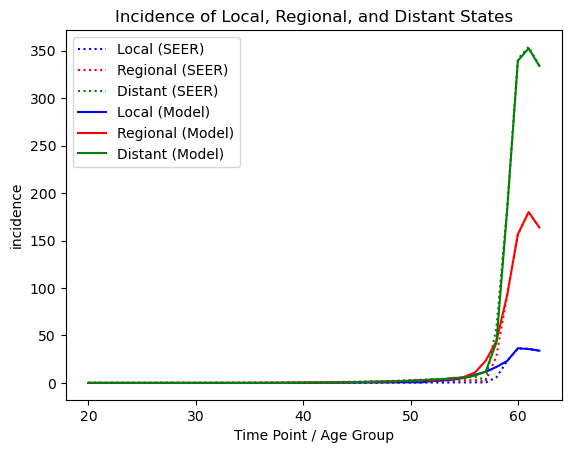

Simulated annealing progress:  25%|██▌       | 25022/100000 [02:14<06:07, 204.13iteration/s]

25000: Best Eval: 609.75808, PDAC: 0.01918, Tick: 19


Simulated annealing progress:  30%|██▉       | 29994/100000 [02:39<05:48, 201.12iteration/s]

30000: Best Eval: 255.88592, PDAC: 0.01899, Tick: 0
Detailed Progress Report, Iteration = 30000
   From State    To State   Age 30   Age 75      Min      Max      Avg
0     healthy  u_PDAC_loc  0.00000  0.00044  0.00000  0.00632  0.00073
1  u_PDAC_loc  u_PDAC_reg  0.14007  0.21068  0.10793  0.36907  0.18073
2  u_PDAC_reg  u_PDAC_dis  0.27514  0.49975  0.21804  0.83627  0.40990
3  u_PDAC_loc  d_PDAC_loc  0.02205  0.02029  0.00730  0.02810  0.01984
4  u_PDAC_reg  d_PDAC_reg  0.29325  0.25928  0.08047  0.38208  0.26181
5  u_PDAC_dis  d_PDAC_dis  0.54205  0.51850  0.20358  0.80159  0.53304


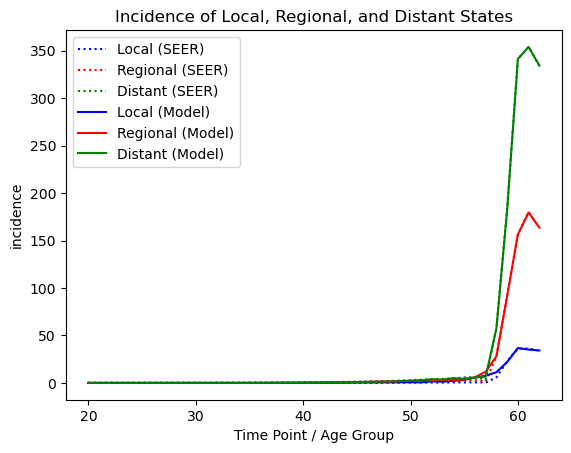

Simulated annealing progress:  35%|███▌      | 35031/100000 [03:05<05:22, 201.32iteration/s]

35000: Best Eval: 141.74814, PDAC: 0.01892, Tick: 2


Simulated annealing progress:  40%|███▉      | 39999/100000 [03:30<05:28, 182.51iteration/s]

40000: Best Eval: 90.97665, PDAC: 0.01884, Tick: 56
Detailed Progress Report, Iteration = 40000
   From State    To State   Age 30   Age 75      Min      Max      Avg
0     healthy  u_PDAC_loc  0.00000  0.00044  0.00000  0.00659  0.00072
1  u_PDAC_loc  u_PDAC_reg  0.14007  0.21068  0.09731  0.38291  0.18135
2  u_PDAC_reg  u_PDAC_dis  0.27514  0.49975  0.21804  0.87442  0.41113
3  u_PDAC_loc  d_PDAC_loc  0.02205  0.02029  0.00521  0.02882  0.01980
4  u_PDAC_reg  d_PDAC_reg  0.29325  0.25928  0.06783  0.36626  0.26101
5  u_PDAC_dis  d_PDAC_dis  0.54205  0.51850  0.18039  0.80154  0.53339


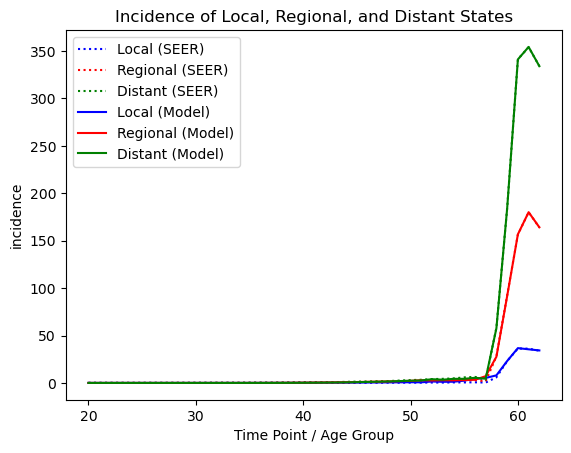

Simulated annealing progress:  45%|████▌     | 45034/100000 [04:03<04:47, 190.91iteration/s]

45000: Best Eval: 55.84791, PDAC: 0.01881, Tick: 1


Simulated annealing progress:  50%|████▉     | 49998/100000 [04:35<04:05, 203.27iteration/s]

50000: Best Eval: 41.35791, PDAC: 0.01876, Tick: 8
Detailed Progress Report, Iteration = 50000
   From State    To State   Age 30   Age 75      Min      Max      Avg
0     healthy  u_PDAC_loc  0.00000  0.00044  0.00000  0.00671  0.00073
1  u_PDAC_loc  u_PDAC_reg  0.14007  0.21068  0.10017  0.39157  0.18109
2  u_PDAC_reg  u_PDAC_dis  0.27514  0.49975  0.21804  0.88229  0.41035
3  u_PDAC_loc  d_PDAC_loc  0.02205  0.02029  0.00276  0.02936  0.01973
4  u_PDAC_reg  d_PDAC_reg  0.29325  0.25928  0.05593  0.38635  0.26004
5  u_PDAC_dis  d_PDAC_dis  0.54205  0.51850  0.17281  0.80224  0.53669


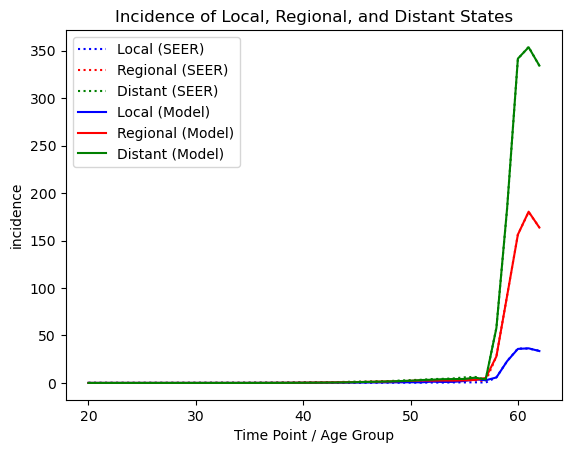

Simulated annealing progress:  55%|█████▌    | 55014/100000 [05:32<08:42, 86.16iteration/s] 

55000: Best Eval: 30.83065, PDAC: 0.01877, Tick: 2


Simulated annealing progress:  60%|█████▉    | 59989/100000 [06:29<06:12, 107.51iteration/s]

60000: Best Eval: 23.95092, PDAC: 0.01875, Tick: 48
Detailed Progress Report, Iteration = 60000
   From State    To State   Age 30   Age 75      Min      Max      Avg
0     healthy  u_PDAC_loc  0.00000  0.00044  0.00000  0.00690  0.00074
1  u_PDAC_loc  u_PDAC_reg  0.14007  0.21068  0.08967  0.39604  0.18109
2  u_PDAC_reg  u_PDAC_dis  0.27514  0.49975  0.21804  0.89971  0.41248
3  u_PDAC_loc  d_PDAC_loc  0.02205  0.02029  0.00159  0.02982  0.01974
4  u_PDAC_reg  d_PDAC_reg  0.29325  0.25928  0.04927  0.39233  0.25933
5  u_PDAC_dis  d_PDAC_dis  0.54205  0.51850  0.16499  0.80395  0.53635


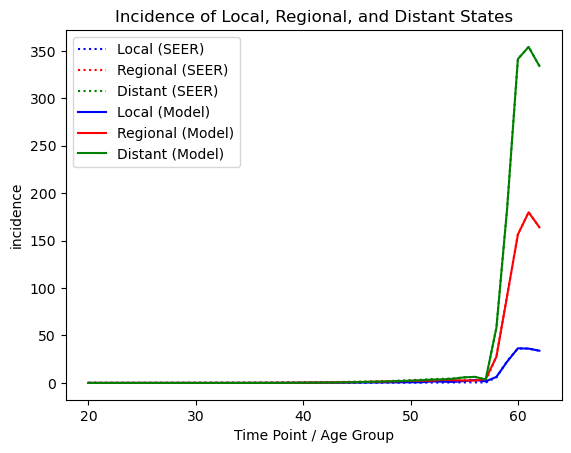

Simulated annealing progress:  65%|██████▌   | 65033/100000 [07:19<03:20, 174.15iteration/s]

65000: Best Eval: 18.94027, PDAC: 0.01874, Tick: 107


Simulated annealing progress:  70%|██████▉   | 69993/100000 [08:00<02:37, 190.54iteration/s]

70000: Best Eval: 17.90692, PDAC: 0.01875, Tick: 1496
Detailed Progress Report, Iteration = 70000
   From State    To State   Age 30   Age 75      Min      Max      Avg
0     healthy  u_PDAC_loc  0.00000  0.00044  0.00000  0.00688  0.00072
1  u_PDAC_loc  u_PDAC_reg  0.14007  0.21068  0.09689  0.39704  0.18198
2  u_PDAC_reg  u_PDAC_dis  0.27514  0.49975  0.21804  0.89992  0.41231
3  u_PDAC_loc  d_PDAC_loc  0.02205  0.02029  0.00084  0.03200  0.01977
4  u_PDAC_reg  d_PDAC_reg  0.29325  0.25928  0.04763  0.39546  0.25944
5  u_PDAC_dis  d_PDAC_dis  0.54205  0.51850  0.14036  0.80164  0.53581


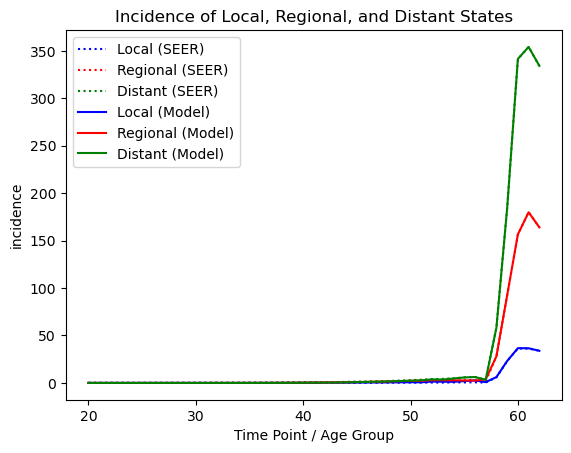

Simulated annealing progress:  75%|███████▍  | 74936/100000 [08:45<02:10, 191.38iteration/s]

In [ ]:
result=np.load("../out/tmats/20241220_0922_tmat.npy")
for epoch in range(3):
    print(f"EPOCH {(epoch+1)}/3 ----------------------------------------------------------")
    result = run_sa(tmat=result, save_all=True, n_iterations=100000, step_size=0.2, n_adj=3, starting_temp=5)

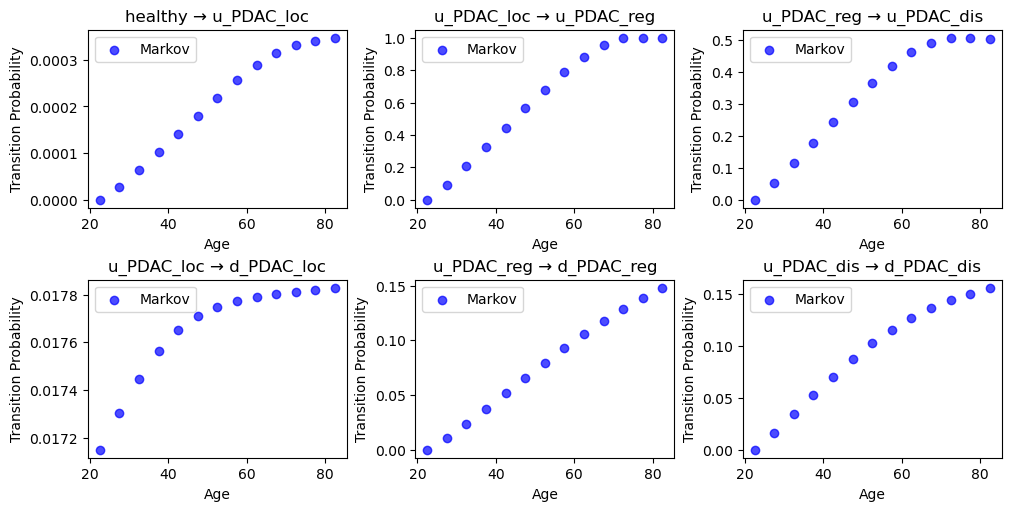

In [160]:
tmat = np.load("../out/tmats/20241219_1748_tmat.npy")
p.plot_params(tmat, show_plot=True)

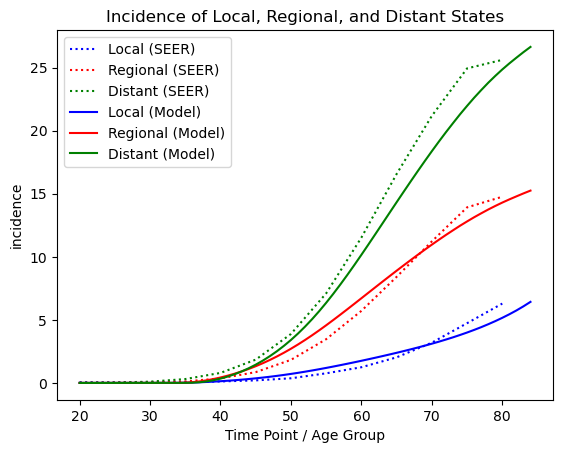

In [158]:
temp = tmat.copy()

# Healthy to local
temp[:30, 0, 1] *= 0.2
temp[30:, 0, 1] *= 1.2
temp[50:, 0, 1] *= 1.4

# Loc to Reg
temp[:, 1, 2] = 0.2
temp[50:, 1, 2] = np.linspace(0.2, 0.05, 15)

# Reg to Dis
temp[:, 2, 3] = 0.45
temp[25:35, 2, 3] = np.linspace(0.45, 0.55, 10)
temp[35:, 2, 3] = 0.55
temp[50:, 2, 3] = np.linspace(0.55, 0.5, 15)

# Detection
temp[:, 2, 5] = 0.3
temp[:, 3, 6] = 0.50

temp = temp[::5,:,:]
tmat_smoothed = csaps([22.5,27.5,32.5,37.5,42.5,47.5,52.5,57.5,62.5,67.5,72.5,77.5,82.5], temp, axis=0, smooth=0.001)(c.ages_1y)
tmat_smoothed = add_acm(tmat_smoothed)
tmat_smoothed = add_csd(tmat_smoothed)
tmat_smoothed = constrain_matrix(tmat_smoothed)
tmat_smoothed = row_normalize(tmat_smoothed)
p.plot_vs_seer(run_markov(tmat_smoothed)[0], c.seer_inc, show_plot=True)

In [159]:
np.save("../out/tmats/20241219_2250.npy", tmat_smoothed)

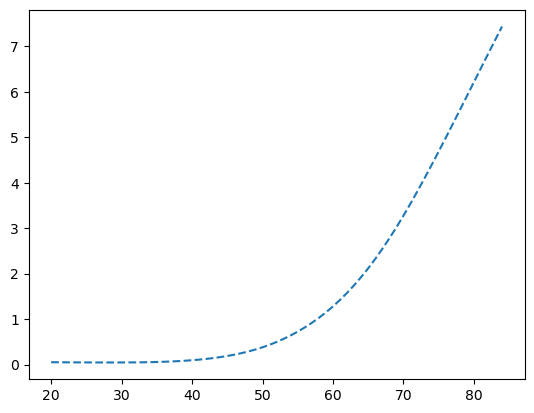

In [56]:
smooth=csaps(c.ages_5y, c.seer_inc_nod['LocalU'], smooth=0.01)(c.ages_1y)
plt.plot(c.ages_1y, smooth, linestyle="--")

## Post-processing

In [28]:
def smooth_tmat(mat, save=False, outpath=c.OUTPUT_PATHS['tmats'], timestamp=""): # (sex: 2, race: 2, age_buckets: 10, state: 18, state: 18)
    
    # Anchor with mean at 100 and Smooth interpolation over age
    tmat_anchored = np.concatenate([mat, np.minimum(mat[-1:, :, :], np.mean(mat, axis=0, keepdims=True))], axis=0) # take mean of values over age buckets and set at age 100 (only if mean lower than last age bucket)
    tmat = csaps([25,35,45,52.5,57.5,62.5,67.5,72.5,77.5,82.5], mat, smooth=0.01, axis=0)(np.linspace(20,100,81)) # interpolation without anchoring
    tmat_anchored = csaps([25,35,45,52.5,57.5,62.5,67.5,72.5,77.5,82.5,100], tmat_anchored, smooth=0.01, axis=0)(np.linspace(20,100,81)).clip(0.0, 1.0)

    # If smoothed tmat is exp increasing towards end, used anchored probs
    increasing_at_100 = tmat[-2:-1, :, :] < tmat[-1:, :, :]
    tmat_anchored = np.where(increasing_at_100, tmat_anchored, tmat)
    transition_mask = np.zeros((13, 13), dtype=bool)
    from_states, to_states= c.transitions_itos.keys()
    transition_mask[from_states, to_states] = True
    tmat_anchored = np.where(increasing_at_100 & transition_mask[np.newaxis, ...], tmat_anchored, tmat)

    tmat = tmat_anchored
    tmat = row_normalize(tmat)

    if save:
      os.makedirs(outpath, exist_ok=True)
      name = f"tmat_{timestamp}"
      np.save(f"{outpath}/{name}.npy", tmat)
      
    return tmat

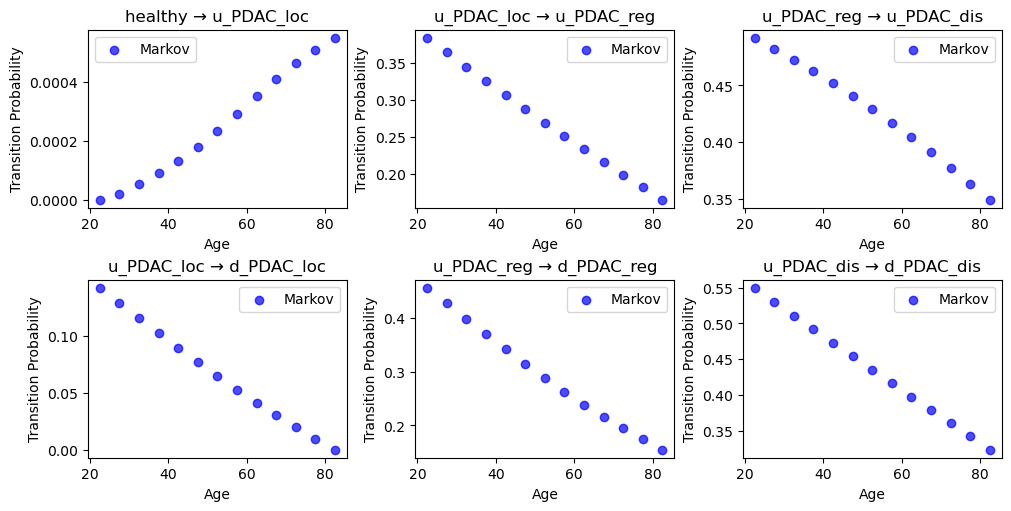

In [31]:
p.plot_params(result, show_plot=True)
markov_tmat = result
treeage_tmat = smooth_tmat(markov_tmat, save=False, timestamp="20241218_1605")
p.plot_params(markov_tmat, treeage_tmat, save_imgs=False, show_plot=True)